# Plots for the speed test of ABCDe algorithm

## Data preprocessing:

In [3]:
using Base.Iterators
using Random
using DataFrames
using PyPlot
using StatsBase

In [9]:
seed = 33;
dir = "speed_test/benchmark_res";

In [10]:
Random.seed!(seed);

In [11]:
#Parameters:
algs = [:LFR, :ABCD, :ABCDe]
n = 10 .^(range(4,9,step = 1))
ξs = range(0.0, 1.0, step = 0.05)
βs = [1.1, 1.5, 1.9]
γs = [2.1, 2.5, 2.9]
min_degs = [5,10];
is_local = [true, false]
threads = [1, 2, 4, 8, 16, 32];

In [14]:
data = DataFrame(vcat(reshape(collect(product([:ABCDe,], n, ξs, NaN, βs, γs, min_degs, NaN, NaN, is_local, threads, NaN)),:), 
    reshape(collect(product([:ABCD,], n, ξs, NaN, βs, γs, min_degs, NaN, NaN, is_local, 1, NaN)),:), 
    reshape(collect(product([:LFR,], n, ξs, NaN, βs, γs, min_degs, NaN, NaN, NaN, 1, NaN)),:)));
rename!(data, [:algo, :n, :ξ, :μ, :β, :γ, :min_deg, :E_deg, :n_edges, :is_local, :threads, :time]);

In [15]:
for file in readdir(dir)
    name = Symbol(split(file,'_')[1])
    n, ξ, μ, β, γ, min_deg, E_deg, n_edges, is_local, threads, time = readlines(dir *"/"* file)
    if name == :LFR
        idx = (data[!,:algo] .== name) .& (data[!,:n] .== parse(Int,n)) .& 
            (data[!,:ξ] .== parse(Float64, ξ)) .& (data[!,:β] .== parse(Float64, β)) .& 
            (data[!,:γ] .== parse(Float64, γ)) .& (data[!,:min_deg] .== parse(Int, min_deg))
    else
        idx = (data[!,:algo] .== name) .& (data[!,:n] .== Int(parse(Float64,n))) .& 
            (data[!,:ξ] .== parse(Float64, ξ)) .& (data[!,:β] .== parse(Float64, β)) .& 
            (data[!,:γ] .== parse(Float64, γ)) .& (data[!,:min_deg] .== Int(parse(Float64, min_deg)))  .& 
            (data[!,:is_local] .== parse(Float64,is_local)) .& (data[!, :threads] .== Int(parse(Float64, threads)))
    end
    data[idx, :E_deg] .= parse(Float64, E_deg)
    data[idx, :n_edges] .= Int(parse(Float64, n_edges))
    data[idx, :μ] .= parse(Float64, μ)
    data[idx, :time] .= parse(Float64, time)
end

In [16]:
size(data)

(34020, 12)

In [17]:
fdata = data[(data[!,:n] .≤ 10^9) .& (isnan.(data[!,:time]) .== false),:];
sort!(fdata);
size(fdata)

(23465, 12)

# Time/n plot

Plotting the relation between the size of graph and the execution time for fixed $\xi$ and $\beta$ and $\gamma$.

In [18]:
#parameters:

ξ = 0.2
β = 1.5
γ = 2.5
min_deg = 5
threads = [1,2,4,8,16,32];

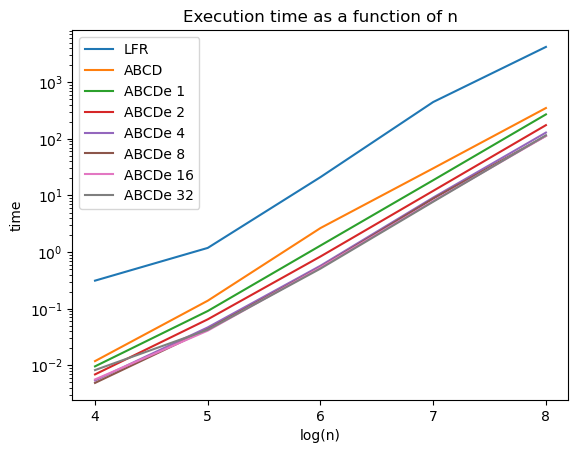

PyObject Text(0.5, 1.0, 'Execution time as a function of n')

In [23]:
group = groupby(groupby(fdata,[:algo,:ξ, :β, :γ, :min_deg])[(:LFR, ξ,β, γ, min_deg)], :n);
y = [mean(d[!,:time]) for d in group]
plot(log.(10,unique(fdata[!,:n])), y, label = "LFR")

group = groupby(groupby(fdata,[:algo,:ξ,:β, :γ, :min_deg])[(:ABCD, ξ, β, γ, min_deg)], :n);
y = [mean(d[!,:time]) for d in group]
plot(log.(10,unique(fdata[!,:n])), y, label = "ABCD")

for thread in threads
    group = groupby(groupby(fdata,[:algo,:ξ, :β, :γ, :min_deg, :threads])[(:ABCDe, ξ, β, γ, min_deg, thread)], :n);
    y = [mean(d[!,:time]) for d in group]
    plot(log.(10,unique(fdata[!,:n])), y, label = "ABCDe $thread")
end

legend(loc="upper left")
xticks(log.(10,unique(fdata[!,:n])))
xlabel("log(n)")
yscale("log")
ylabel("time")
title("Execution time as a function of n")

#saving to a file:
#savefig("fig1.eps")

# Time/ξ plot

Plotting the relation between $\xi$ and the execution time for fixed $n$, $\beta$ and $\gamma$.

In [24]:
#parameters

n = 10^8
β = 1.5
γ = 2.5
min_deg = 5
threads = [1,2,4,8,16,32];

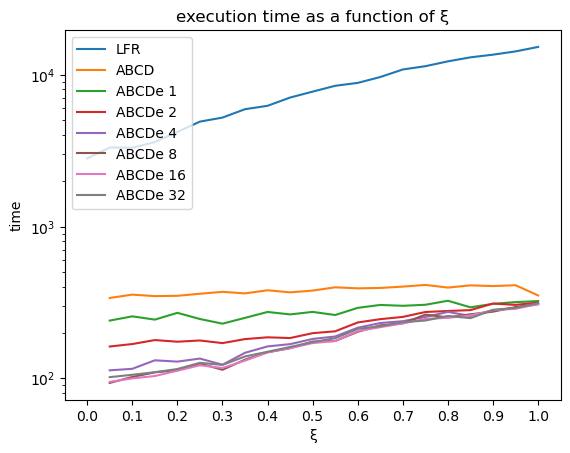

PyObject Text(0.5, 1.0, 'execution time as a function of ξ')

In [25]:
group = groupby(groupby(fdata,[:algo, :n, :β, :γ, :min_deg])[(:LFR, n, β, γ, min_deg)], :ξ);
x,y = collect(zip([(unique(d[!,:ξ])[1], mean(d[!,:time])) for d in group]...))
plot(x, y, label = "LFR")

group = groupby(groupby(fdata,[:algo,:n, :β, :γ, :min_deg])[(:ABCD, n, β, γ, min_deg)], :ξ);
x,y = collect(zip([(unique(d[!,:ξ])[1], mean(d[!,:time])) for d in group]...))
plot(x,y, label = "ABCD")

for thread in threads
    group = groupby(groupby(fdata,[:algo,:n, :β, :γ, :min_deg, :threads])[(:ABCDe, n, β, γ, min_deg, thread)], :ξ);
    x,y = collect(zip([(unique(d[!,:ξ])[1], (mean(d[!,:time]))) for d in group]...))
    plot(x, y, label = "ABCDe $thread")
end

legend(loc="upper left")
xticks(range(0.0, 1.0, step = 0.1))
xlabel("ξ")
yscale("log")
ylabel("time")
title("execution time as a function of ξ")

#saving to a file:
#savefig("fig2.eps")

# β and γ plots

Plotting the relationships between the execution time and $n$ for different values of $\gamma$ and $\beta$.

In [29]:
#parameters:

ξ = 0.2
min_deg = 5
thread = 32

32

Relationship between $n$ and avg exec. time for different values of $\gamma$ and $\beta$:

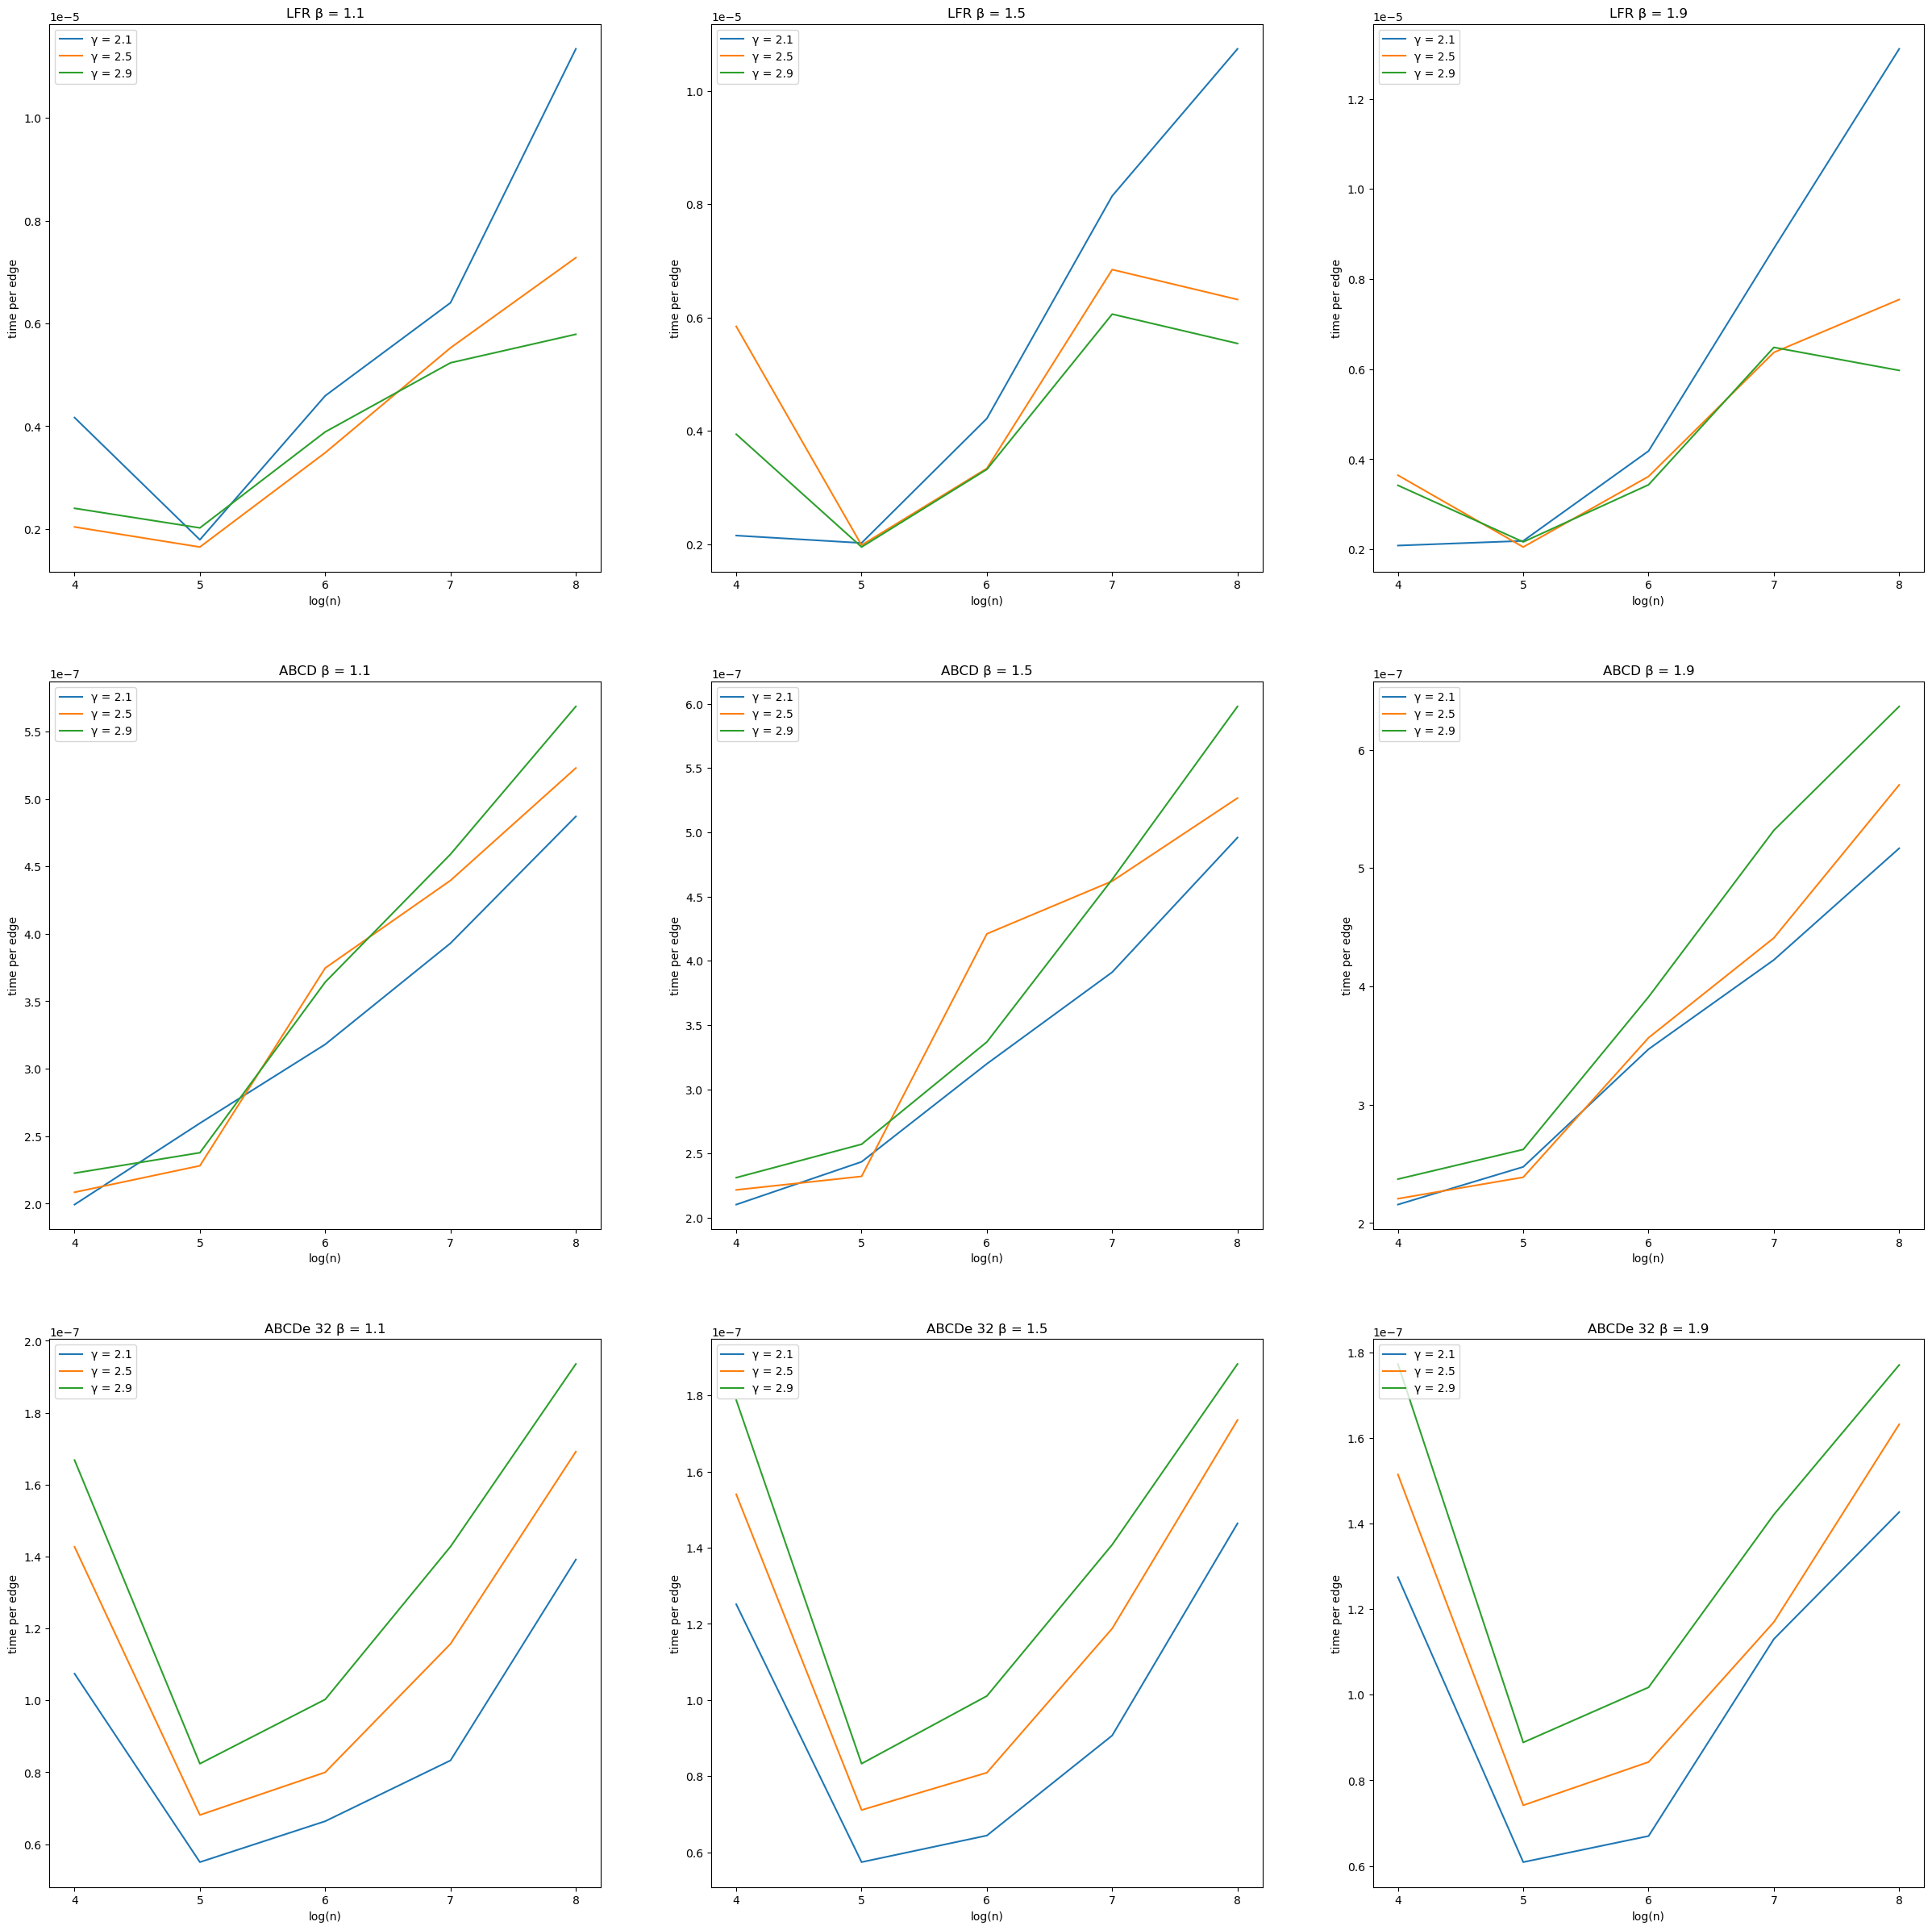

In [31]:
fig = figure("relationship between n and average execution time for different values of γ and β",figsize = (30,30)) 
k = 1
for algo in [:LFR, :ABCD, :ABCDe]
    algo != :ABCDe ? (thr = 1) : (thr = thread)
    for (i,β) in enumerate(βs)
        subplot(parse(Int, "33" * "$k"))
        for (j,γ) in enumerate(γs)
            group = groupby(groupby(fdata, 
                    [:algo, :ξ, :γ, :β, :min_deg, :threads])[(algo, ξ, γ, β, min_deg, thr)], :n);
            y = [mean(d[!,:time] ./ d[!,:n_edges]) for d in group]
            plot(log.(10,unique(fdata[!,:n])), y, label = "γ = $γ")
            legend(loc="upper left")
            xticks(log.(10,unique(fdata[!,:n])))
            xlabel("log(n)")
            ylabel("time per edge")
        end
        algo != :ABCDe ? PyPlot.title("$algo β = $β") : PyPlot.title("$algo $thr β = $β")
        k += 1
    end
end

#saving to a file:
#savefig("fig3.eps")

Relationship between $n$ and avg exec. time for different values of $\beta$ and $\gamma$:

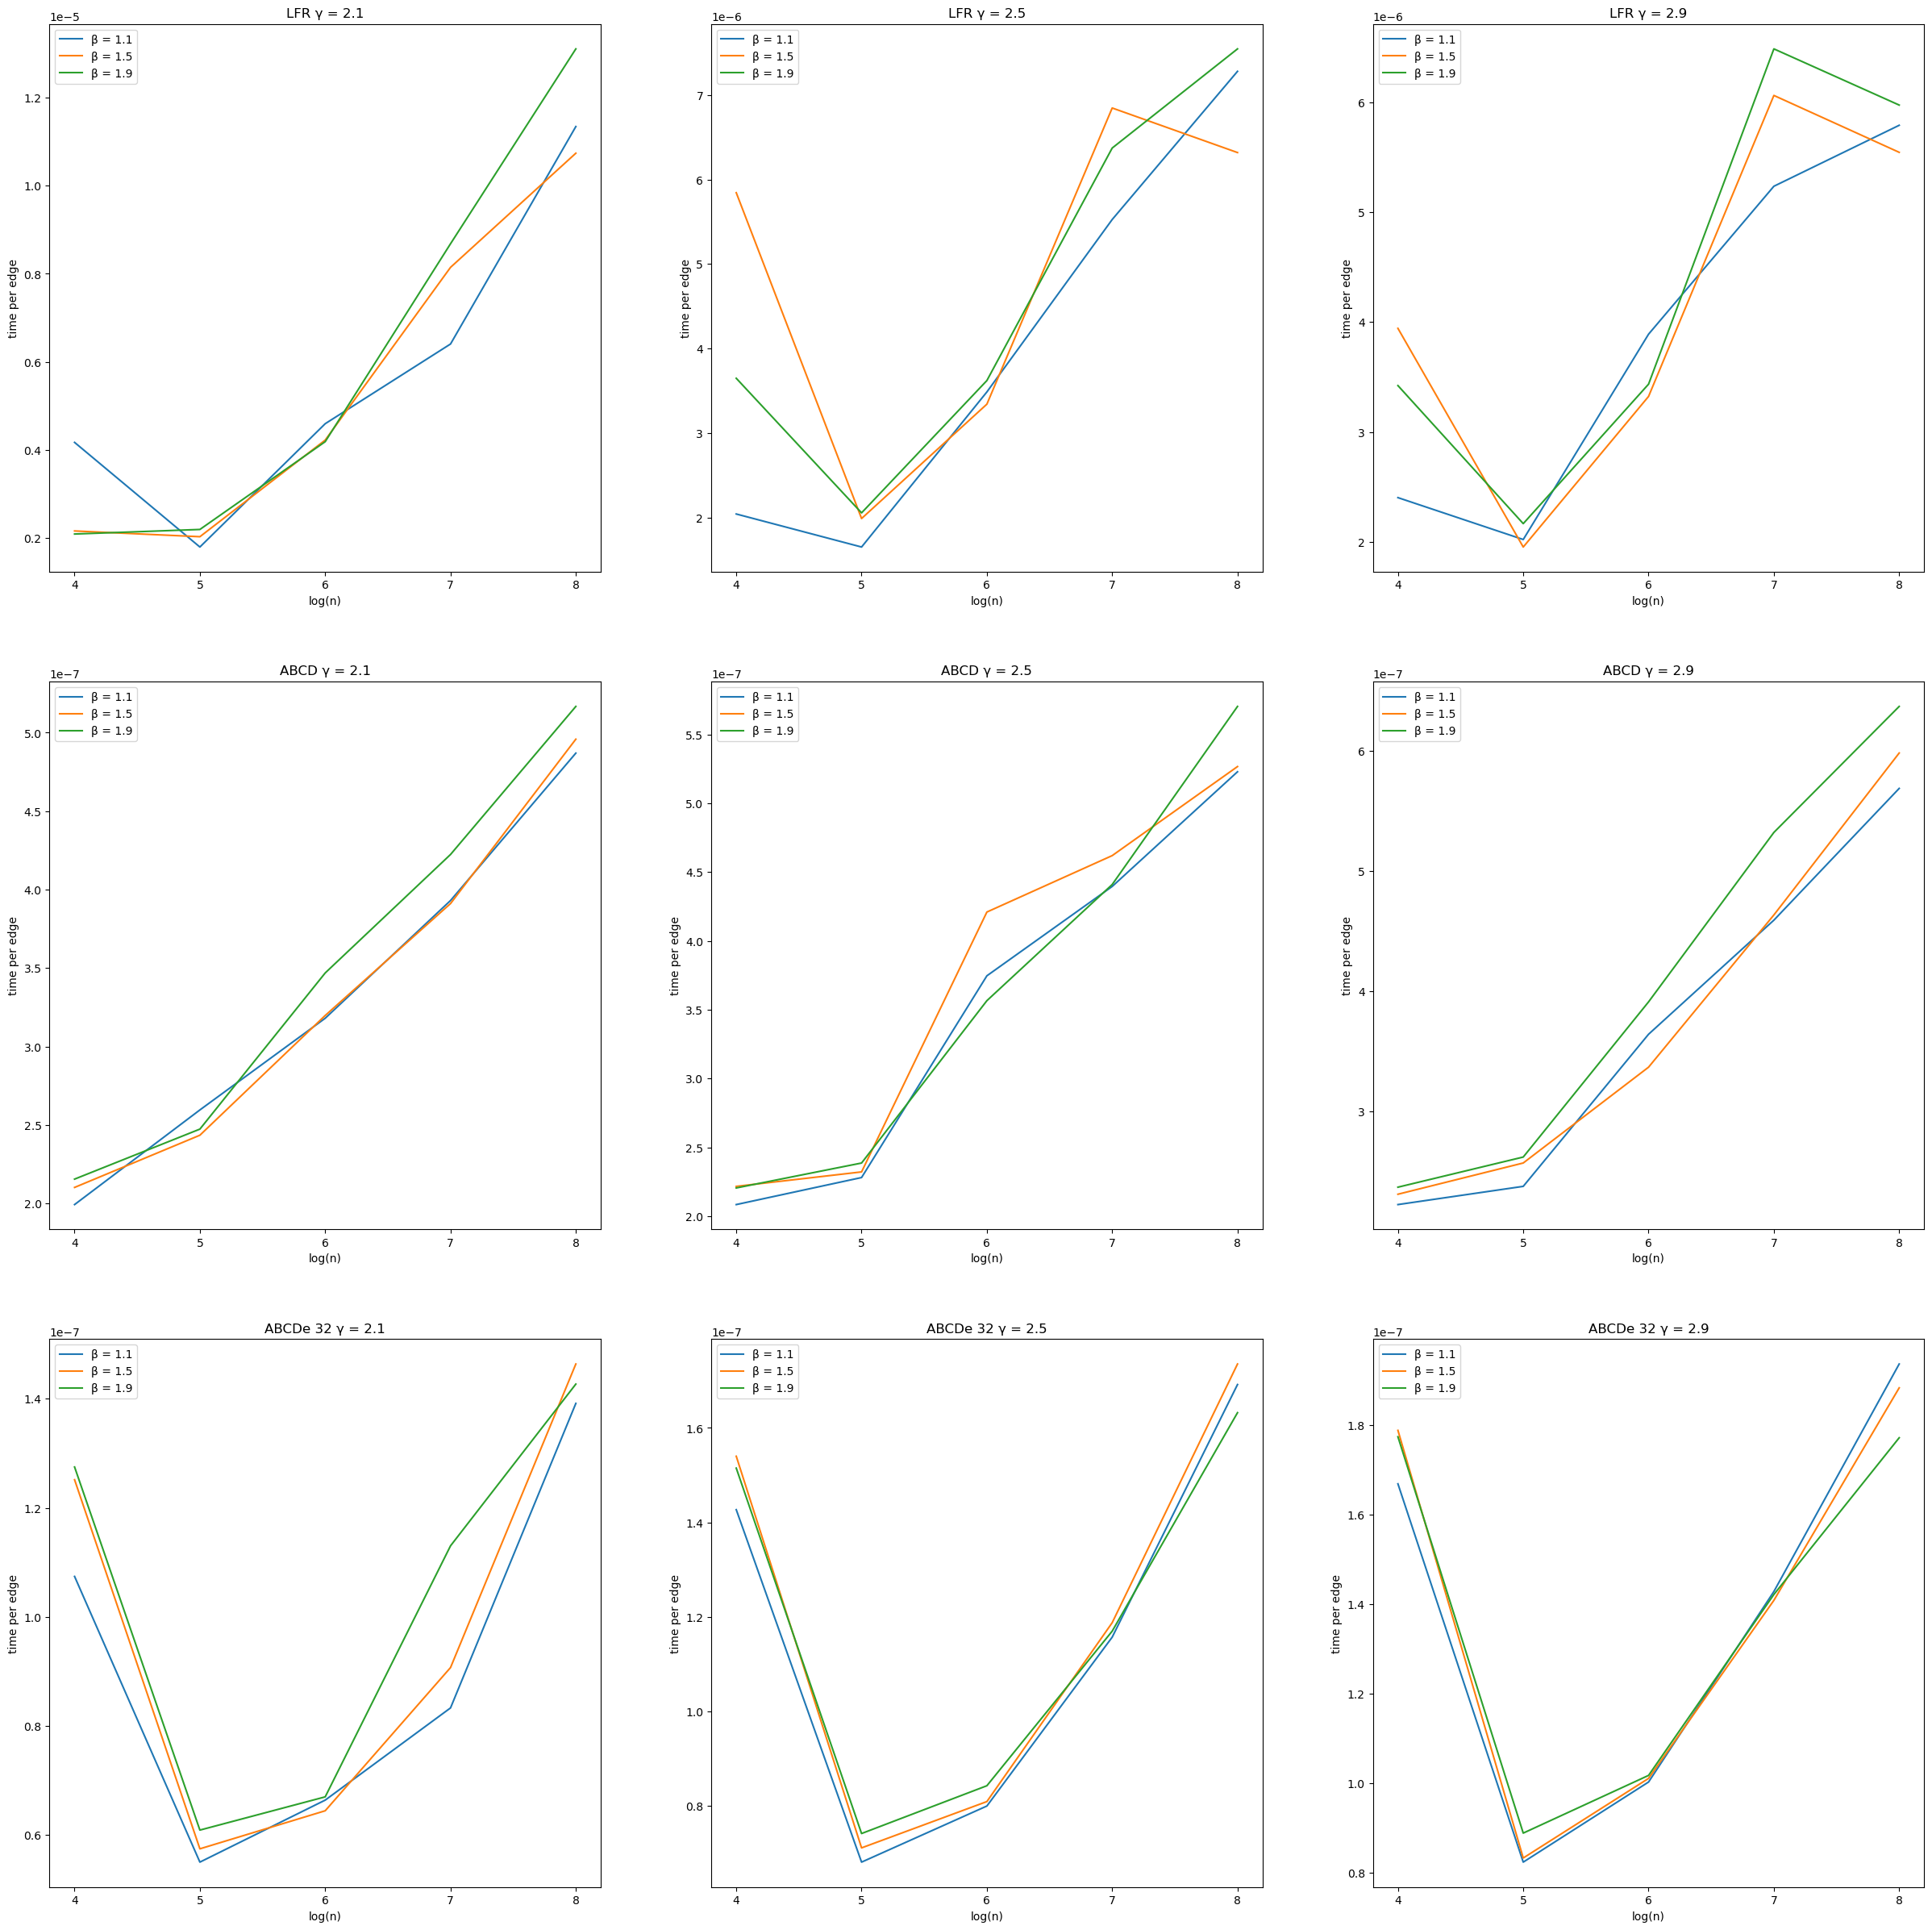

In [33]:
fig = figure("relationship between n and execution time for different values of β and γ",figsize = (30,30)) 
k = 1
for algo in [:LFR, :ABCD, :ABCDe]
    algo != :ABCDe ? (thr = 1) : (thr = thread)
    for (i,γ) in enumerate(γs)
        subplot(parse(Int, "33" * "$k"))
        for (j,β) in enumerate(βs)
            group = groupby(groupby(fdata, 
                    [:algo, :ξ, :γ, :β, :min_deg, :threads])[(algo, ξ, γ, β, min_deg, thr)], :n);
            y = [mean(d[!,:time] ./ d[!,:n_edges]) for d in group]
            plot(log.(10,unique(fdata[!,:n])), y, label = "β = $β")
            legend(loc="upper left")
            xticks(log.(10,unique(fdata[!,:n])))
            xlabel("log(n)")
            ylabel("time per edge")
        end
        algo != :ABCDe ? PyPlot.title("$algo γ = $γ") : PyPlot.title("$algo $thr γ = $γ") 
        k += 1
    end
end

#saving to a file:
#savefig("fig4.eps")

# Min_deg impact plots

Plots showing the relationship between the execution time and $n$ or $\xi$ respectively for different values of minimal degree.

### Relationship between $n$ and average execution time for different values of min. degree:

In [39]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
thread = 8;

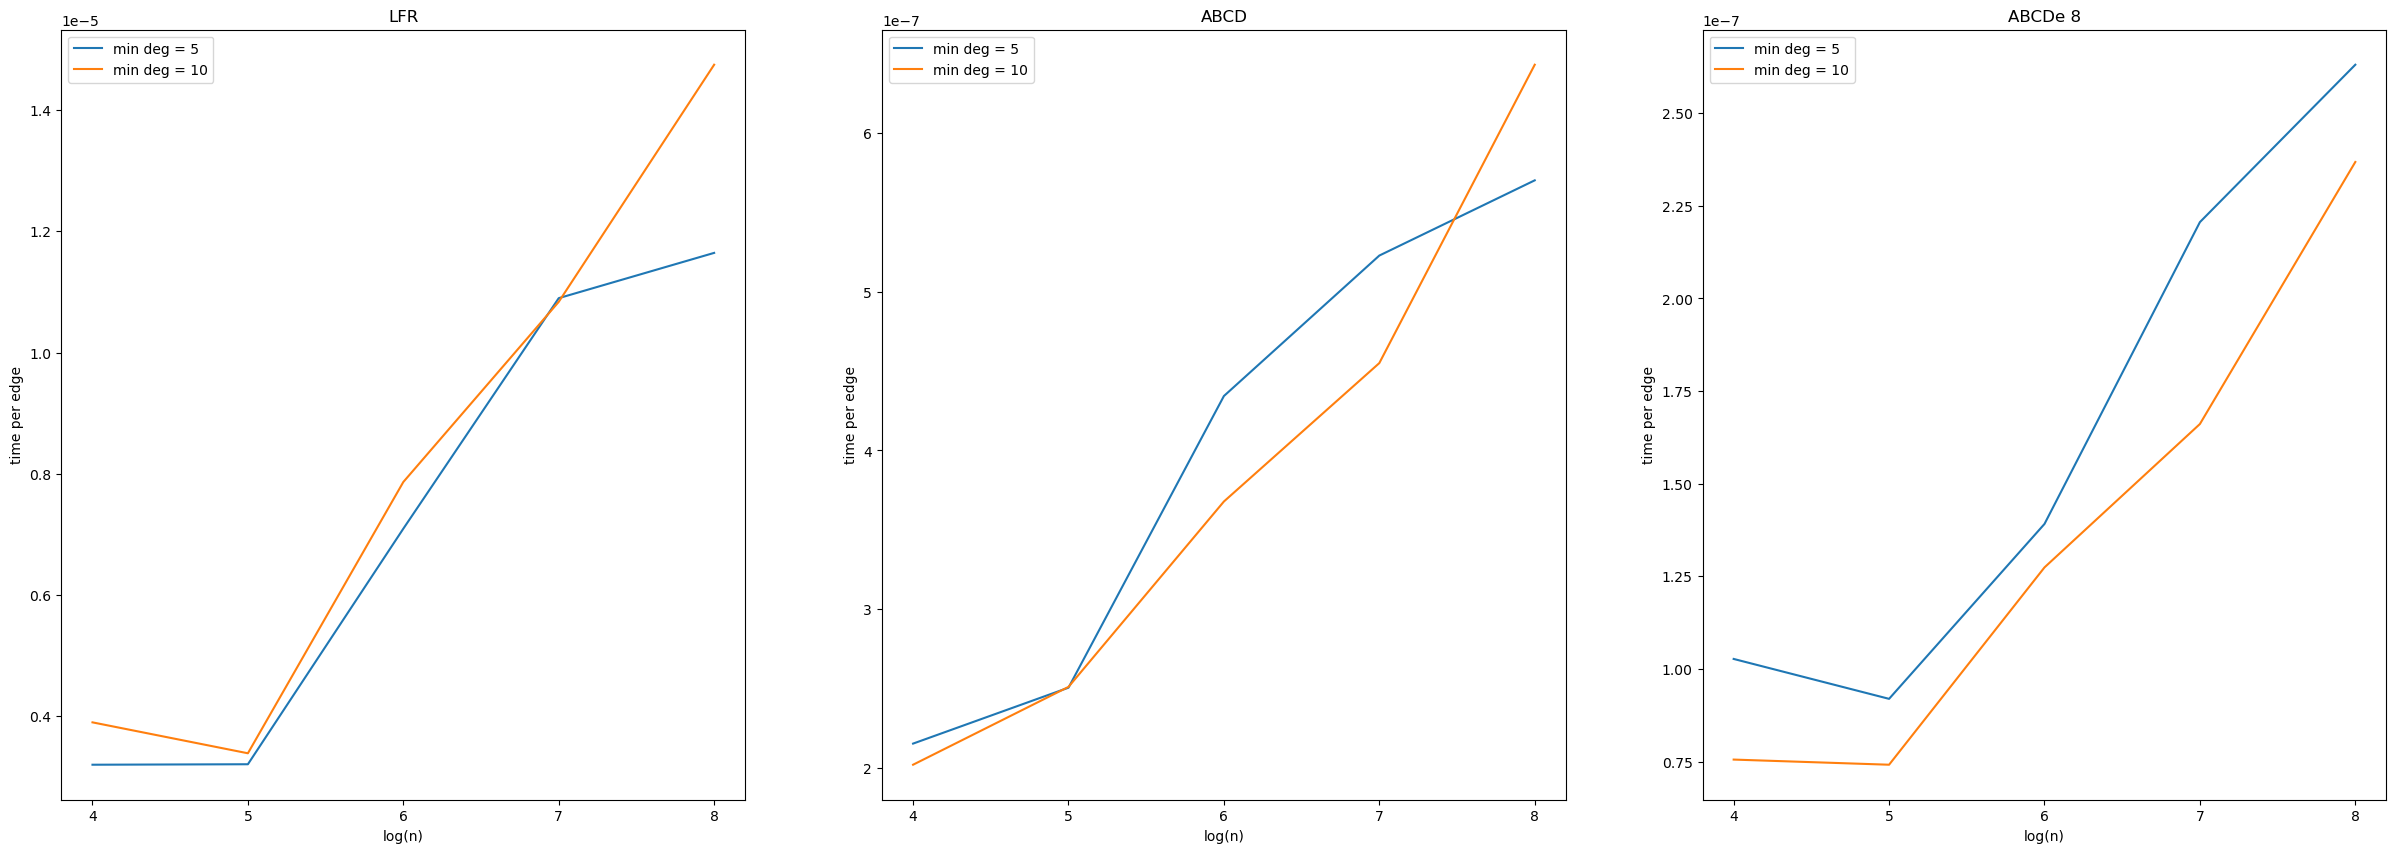

In [40]:
fig = figure("average execution time for different values of min. degree",figsize = (30,10)) 
k = 1
for algo in [:LFR, :ABCD, :ABCDe]
    algo != :ABCDe ? (thr = 1) : (thr = thread)
    subplot(parse(Int, "13" * "$k"))
    for min_deg in min_degs
        group = groupby(groupby(fdata,
                [:algo, :ξ, :β, :γ, :min_deg, :threads])[(algo, ξ, β, γ, min_deg, thr)], :n);
        y = [mean(d[!,:time] ./ d[!,:n_edges]) for d in group]
        plot(log.(10,unique(fdata[!,:n])), y, label = "min deg = $min_deg")
    end
    legend(loc="upper left")
    xticks(log.(10,unique(fdata[!,:n])))
    xlabel("log(n)")
    ylabel("time per edge")
    algo != :ABCDe ? PyPlot.title("$algo") : PyPlot.title("$algo $thr") 
    k += 1
end

#saving to a file:
#savefig("fig5.eps")

### Relationship between $\xi$ and  average execution time for different values of min. degree .

In [43]:
#Parameters:

n = 10^7
β = 1.5
γ = 2.5
thread = 8;

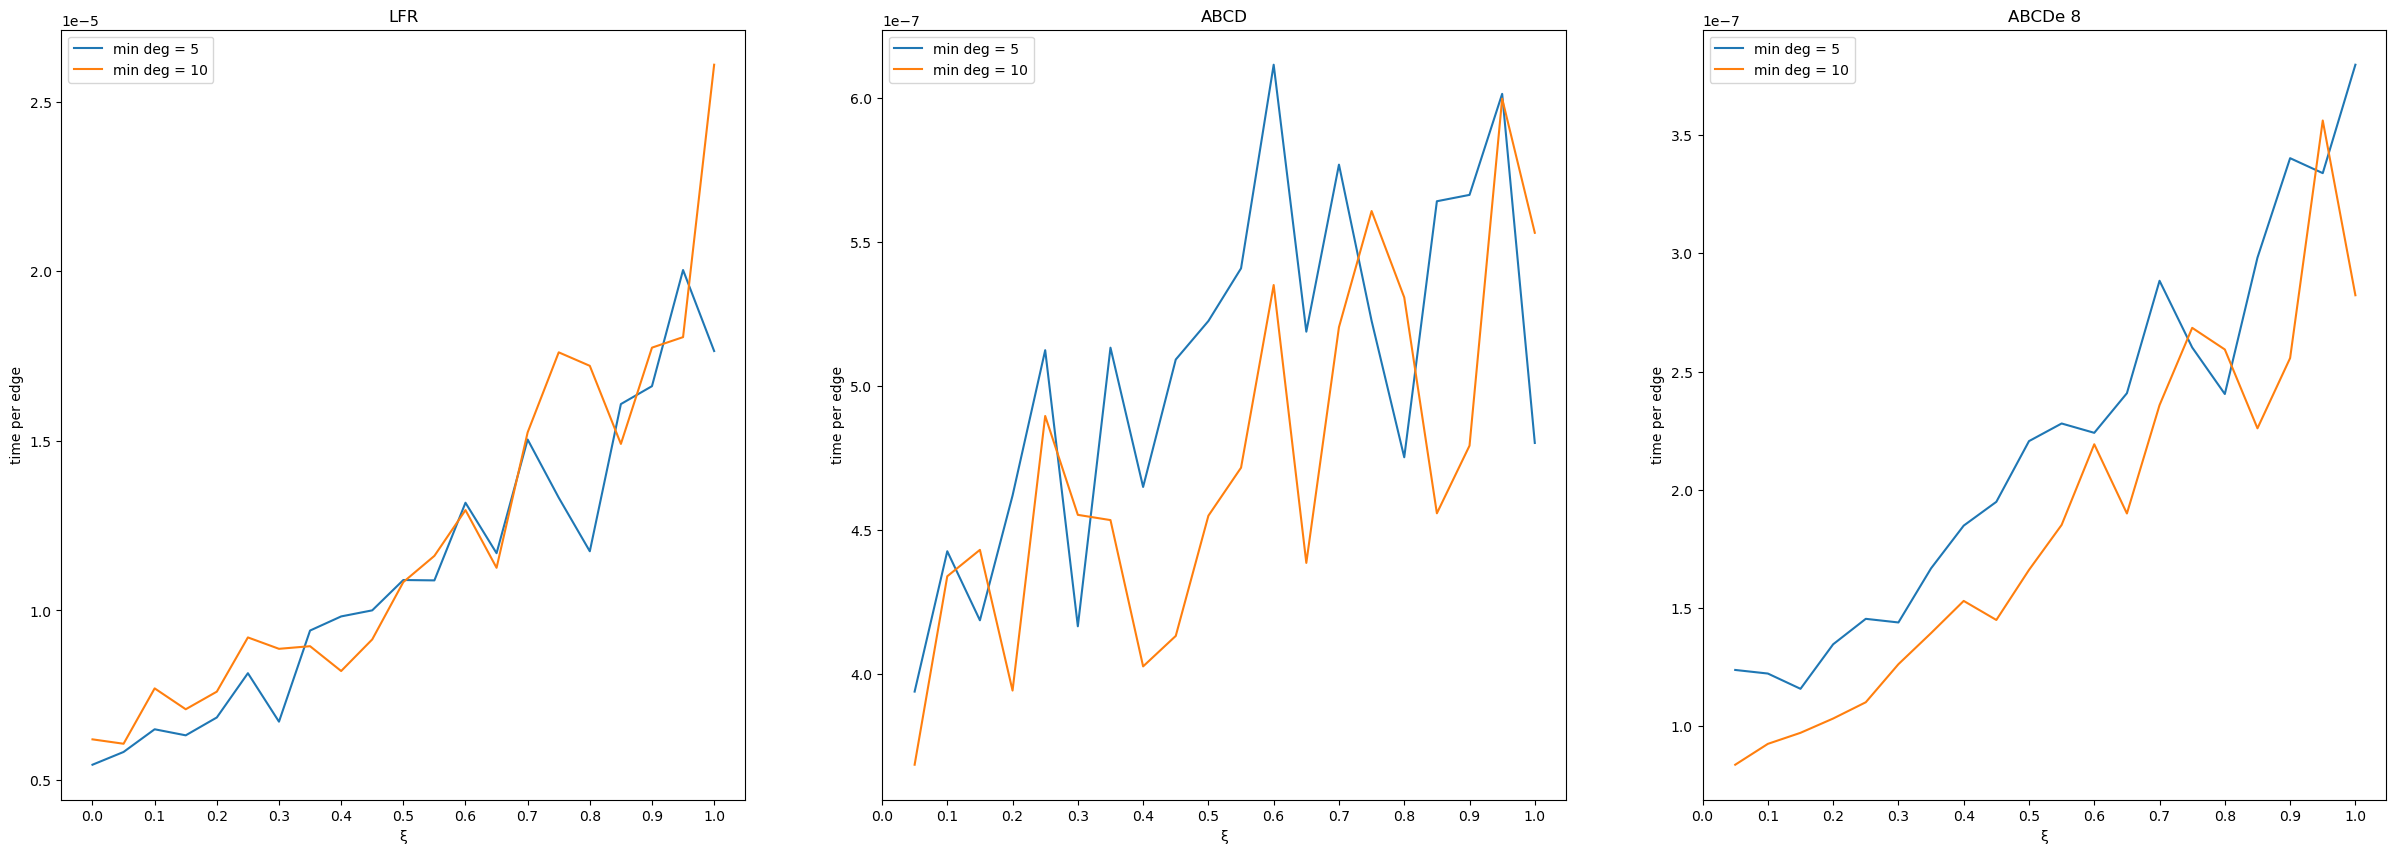

In [45]:
fig = figure("average execution time for different values of min. degree",figsize = (30,10)) 
k = 1
for algo in [:LFR, :ABCD, :ABCDe]
    algo != :ABCDe ? (thr = 1) : (thr = thread)
    subplot(parse(Int, "13" * "$k"))
    for min_deg in min_degs
        group = groupby(groupby(fdata,
                [:algo, :n, :β, :γ, :min_deg, :threads])[(algo, n, β, γ, min_deg, thr)], :ξ);
        x,y = collect(zip([(unique(d[!,:ξ])[1], mean(d[!,:time]./d[!,:n_edges])) for d in group]...))
        plot( x,y, label = "min deg = $min_deg")
    end
    legend(loc="upper left")
    xticks(range(0.0, 1.0, step = 0.1))
    xlabel("ξ")
    ylabel("time per edge")
    algo != :ABCDe ? PyPlot.title("$algo") : PyPlot.title("$algo $thr") 
    k += 1
end

#saving to a file:
#savefig("fig6.eps")

## ABCD vs ABCDe

Detailed comparision of <b>ABCD</b> and <b>ABCDe</b> algorithms (without <b>LFR</b>).

###  Execution time as a function of $n$:

In [49]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 10

10

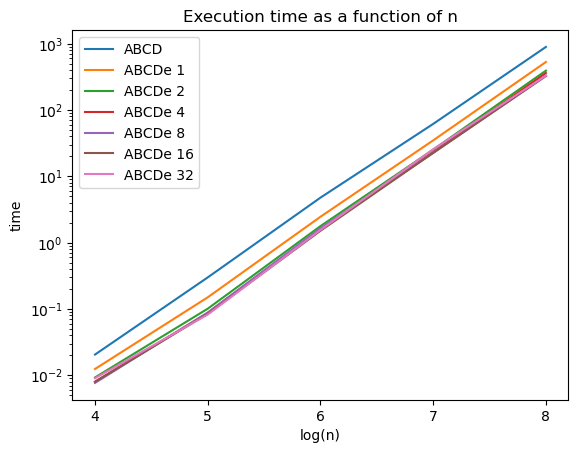

PyObject Text(0.5, 1.0, 'Execution time as a function of n')

In [50]:
group = groupby(groupby(fdata,[:algo,:ξ,:β, :γ, :min_deg])[(:ABCD, ξ, β, γ, min_deg)], :n);
y = [mean(d[!,:time]) for d in group]
plot(log.(10,unique(fdata[!,:n])), y, label = "ABCD")

for thread in threads
    group = groupby(groupby(fdata,[:algo,:ξ, :β, :γ, :min_deg, :threads])[(:ABCDe, ξ, β, γ, min_deg, thread)], :n);
    y = [mean(d[!,:time]) for d in group]
    plot(log.(10,unique(fdata[!,:n])), y, label = "ABCDe $thread")
end

legend(loc="upper left")
xticks(log.(10,unique(fdata[!,:n])))
xlabel("log(n)")
yscale("log")
ylabel("time")
title("Execution time as a function of n")

#saving to a file:
#savefig("fig7.eps")

### Execution time per edge as a function of $n$:

In [51]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 10

10

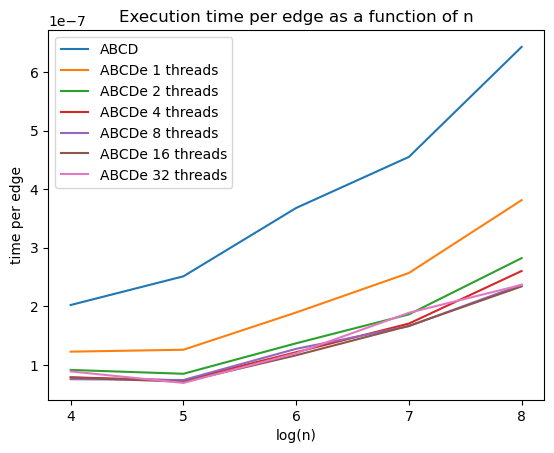

PyObject Text(0.5, 1.0, 'Execution time per edge as a function of n')

In [54]:
group = groupby(groupby(fdata, [:algo,:ξ, :β, :γ, :min_deg])[(:ABCD, ξ, β, γ, min_deg)], :n);
y = [mean(d[!,:time] ./ d[!,:n_edges]) for d in group]
plot(log.(10,unique(fdata[!,:n])), y, label = "ABCD")

for thread in threads
    group = groupby(groupby(fdata, [:algo, :ξ, :β, :γ, :min_deg, :threads])[(:ABCDe, ξ, β, γ, min_deg, thread)], :n);
    y = [mean(d[!,:time] ./ d[!,:n_edges]) for d in group]
    plot(log.(10,unique(fdata[!,:n])), y, label = "ABCDe $thread threads")
end

legend(loc="upper left")
xticks(log.(10,unique(fdata[!,:n])))
xlabel("log(n)")
ylabel("time per edge")
title("Execution time per edge as a function of n")

#saving to a file:
#savefig("fig8.eps")

### Execution time as a function of  $\xi$:

In [62]:
#Parameters:

n = 10^7
β = 1.5
γ = 2.5
min_deg = 10

10

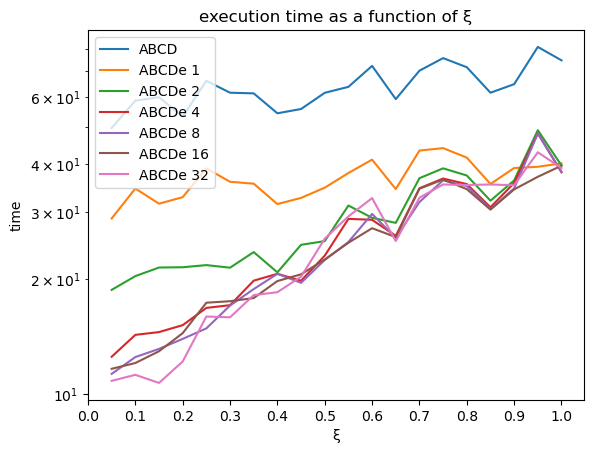

PyObject Text(0.5, 1.0, 'execution time as a function of ξ')

In [63]:
group = groupby(groupby(fdata,[:algo,:n, :β, :γ, :min_deg])[(:ABCD, n, β, γ, min_deg)], :ξ);
x,y = collect(zip([(unique(d[!,:ξ])[1], mean(d[!,:time])) for d in group]...))
plot(x,y, label = "ABCD")

for thread in threads
    group = groupby(groupby(fdata,[:algo,:n, :β, :γ, :min_deg, :threads])[(:ABCDe, n, β, γ, min_deg, thread)], :ξ);
    x,y = collect(zip([(unique(d[!,:ξ])[1], (mean(d[!,:time]))) for d in group]...))
    plot(x, y, label = "ABCDe $thread")
end

legend(loc="upper left")
xticks(range(0.0, 1.0, step = 0.1))
xlabel("ξ")
yscale("log")
ylabel("time")
title("execution time as a function of ξ")

#saving to a file:
#savefig("fig9.eps")

### Execution time per edge as a function of  $\xi$:

In [65]:
#Parameters:

n = 10^7
β = 1.5
γ = 2.5
min_deg = 10

10

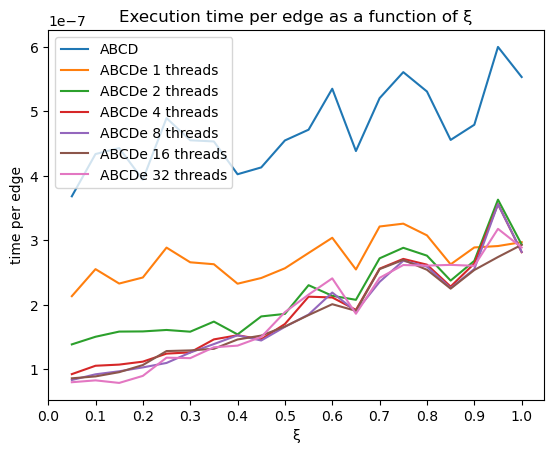

PyObject Text(0.5, 1.0, 'Execution time per edge as a function of ξ')

In [66]:
group = groupby(groupby(fdata, [:algo, :n, :β, :γ, :min_deg])[(:ABCD, n, β, γ, min_deg)], :ξ);
x,y = collect(zip([(unique(d[!,:ξ])[1], mean(d[!,:time]./d[!,:n_edges])) for d in group]...))
plot( x,y, label = "ABCD")

for thread in threads
    group = groupby(groupby(fdata, [:algo, :n, :β, :γ, :min_deg, :threads])[(:ABCDe, n, β, γ, min_deg, thread)], :ξ);
    x,y = collect(zip([(unique(d[!,:ξ])[1], mean(d[!,:time]./d[!,:n_edges])) for d in group]...))
    plot( x,y, label = "ABCDe $thread threads")
end
legend(loc="upper left")
xticks(range(0.0, 1.0, step = 0.1))
xlabel("ξ")
ylabel("time per edge")
title("Execution time per edge as a function of ξ")

#saving to a file:
#savefig("fig10.eps")

## ABCD and ABCDe is_local plots

Comparision between local and global versions of algorithm:

### Execution time per edge as function of $n$ (ABCD):

In [86]:
#Parameters

ξ = 0.2
ξ = 0.7
min_deg = 5
is_local = [0.0,1.0];

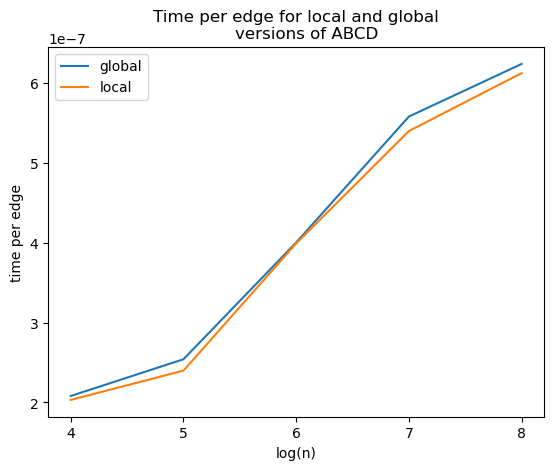

PyObject Text(0.5, 1.0, 'Time per edge for local and global\n    versions of ABCD')

In [88]:
for islocal in is_local
    group = groupby(groupby(fdata, [:algo, :ξ, :is_local, :min_deg])[(:ABCD, ξ, islocal, min_deg)], :n);
    y = [mean(d[!,:time]./d[!,:n_edges]) for d in group]
    plot(log.(10,unique(fdata[!,:n])), y,  label = Bool(islocal) ? "local" : "global")
end

legend(loc="upper left")
xticks(log.(10,unique(fdata[!,:n])))
xlabel("log(n)")
ylabel("time per edge")
title("Time per edge for local and global
    versions of ABCD")

#saving to a file:
#savefig("fig11.eps")

### Execution time per edge as function of $\xi$ (ABCD):

In [101]:
#Parameters

ξ = 0.2
n = 10^7
min_deg = 5
is_local = [0.0,1.0];

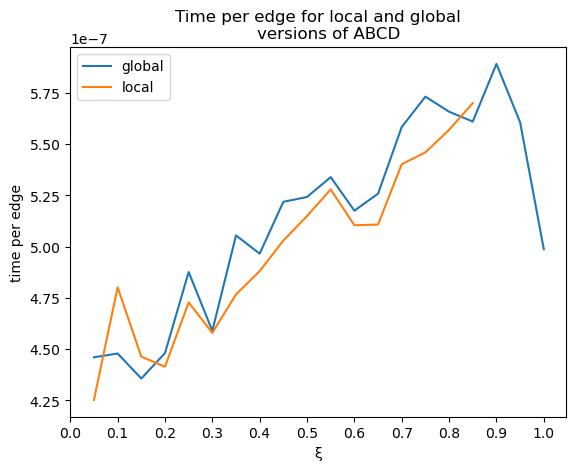

PyObject Text(0.5, 1.0, 'Time per edge for local and global\n    versions of ABCD')

In [102]:
for islocal in is_local
    group = groupby(groupby(fdata, [:algo, :n, :min_deg, :is_local])[(:ABCD, n, min_deg, islocal)], :ξ);
    x,y = collect(zip([(unique(d[!,:ξ])[1], mean(d[!,:time]./d[!,:n_edges])) for d in group]...))
    plot( x,y, label = Bool(islocal) ? "local" : "global")
end

legend(loc="upper left")
xticks(range(0.0, 1.0, step = 0.1))
xlabel("ξ")
ylabel("time per edge")
title("Time per edge for local and global
    versions of ABCD")

#saving to a file:
#savefig("fig12.eps")

### Execution time per edge as function of $n$ (ABCDe):

In [92]:
#Parameters:

ξ = 0.2
n = 10^5
min_deg = 5
thread = 4
is_local = [0.0,1.0];

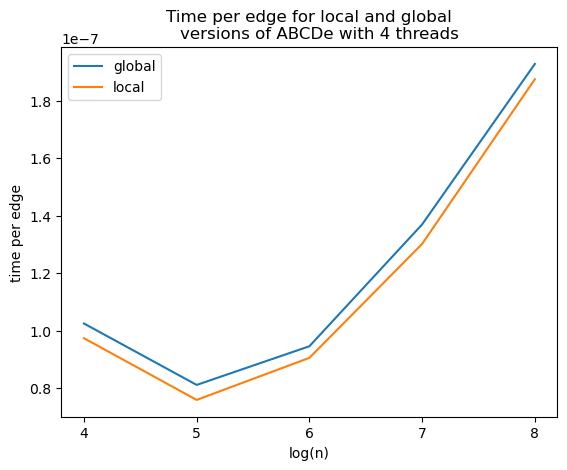

PyObject Text(0.5, 1.0, 'Time per edge for local and global\n    versions of ABCDe with 4 threads')

In [93]:
for islocal in is_local
    group = groupby(groupby(fdata, [:algo, :ξ, :is_local, :min_deg, :threads])[(:ABCDe, ξ, islocal, min_deg, thread)], :n);
    y = [mean(d[!,:time]./d[!,:n_edges]) for d in group]
    plot(log.(10,unique(fdata[!,:n])), y,  label = Bool(islocal) ? "local" : "global")
end

legend(loc="upper left")
xticks(log.(10,unique(fdata[!,:n])))
xlabel("log(n)")
ylabel("time per edge")
title("Time per edge for local and global
    versions of ABCDe with $thread threads")

#saving to a file:
#savefig("fig13.eps")

### Execution time per edge as function of $\xi$ (ABCDe):

In [105]:
#Parameters

ξ = 0.2
n = 10^6
min_deg = 5
is_local = [0.0,1.0];

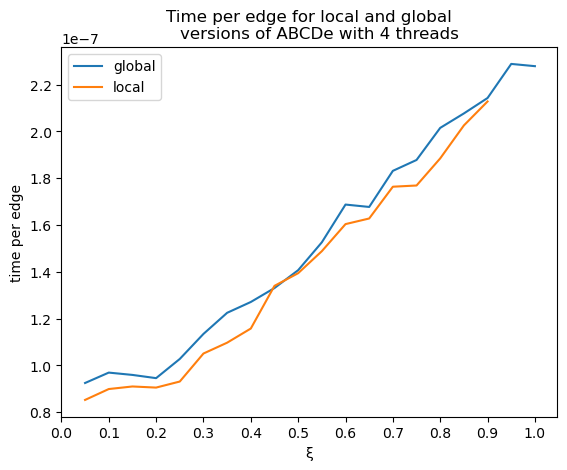

PyObject Text(0.5, 1.0, 'Time per edge for local and global\n    versions of ABCDe with 4 threads')

In [106]:
for islocal in is_local
    group = groupby(groupby(fdata, [:algo, :n, :is_local, :min_deg, :threads])[(:ABCDe, n, islocal, min_deg, thread)], :ξ)
    x,y = collect(zip([(unique(d[!,:ξ])[1], mean(d[!,:time]./d[!,:n_edges])) for d in group]...))
    plot( x,y, label = Bool(islocal) ? "local" : "global")
end

legend(loc="upper left")
xticks(range(0.0, 1.0, step = 0.1))
xlabel("ξ")
ylabel("time per edge")
title("Time per edge for local and global
    versions of ABCDe with $thread threads")

#saving to a file:
#savefig("fig14.eps")